## Introduction

The Keras *functional API* is a way to create models that are more flexible
than the `tf.keras.Sequential` API. The functional API can handle models
with non-linear topology, shared layers, and even multiple inputs (or) outputs.

The main idea is that a deep learning model is usually
a directed acyclic graph (DAG) of layers.
So the functional API is a way to build *graphs of layers*.

Consider the following model:

<div class="k-default-codeblock">
```
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
```
</div>

This is the basic graph with three layers.
To build this model using the functional API, start by creating an input node:

## Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
inputs = keras.Input(shape=(784,))

The shape of the data is set as a 784-dimensional vector.
The batch size is always omitted since only the shape of each sample is specified.

For example, you have an image input with a shape of `(32, 32, 3)`,
you would use:

In [ ]:
# Just for demonstration purposes.
img_inputs = keras.Input(shape=(32, 32, 3))

The `inputs` that is returned contains information about the shape and `dtype`
of the input data that you feed to your model.
Here's the shape:

In [ ]:
inputs.shape

TensorShape([None, 784])

Here is the dtype:

In [ ]:
inputs.dtype

tf.float32

You can create a new node in the graph of layers by calling a layer on this `inputs`
object:

In [ ]:
dense = layers.Dense(64, activation="relu")
x = dense(inputs)

The "layer call" action is like drawing an arrow from "inputs" to this layer
you created.
You are "passing" the inputs to the `dense` layer, and you will get `x` as the output.

Let's add some more layers to the graph of layers:

In [ ]:
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

At this point, you can create a `Model` by specifying it's inputs and outputs
in the graph of layers:

In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

Let's check out what the model summary looks like:

In [ ]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


You can also plot the model as a graph:

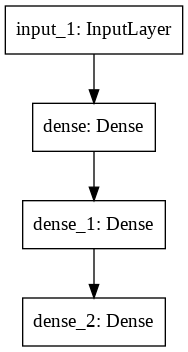

In [ ]:
keras.utils.plot_model(model, "my_first_model.png")

And, optionally, display the input and output shapes of each layer
in the plotted graph:

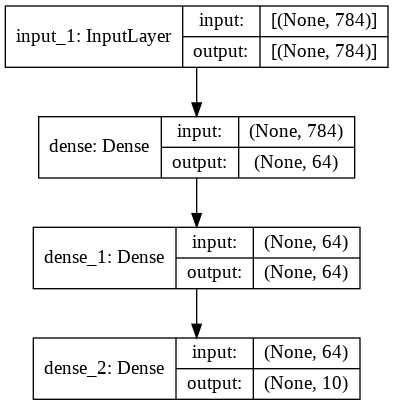

In [ ]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

This figure and the code are almost similar. In this code version,
the connection arrows are replaced by the call operation.

A "graph of layers" is an intuitive mental image for a deep learning model,
and the functional API is a way to create models that closely mirrors this.

## Training, evaluation, and inference

Training, evaluation, and inference work exactly in the same way for models
built using the functional API as for `Sequential` models.

The `Model` class offers a built-in training loop (the `fit()` method)
and a built-in evaluation loop (the `evaluate()` method). Note
that you can easily [customize these loops](/guides/customizing_what_happens_in_fit/)
to implement training routines beyond supervised learning
(e.g. [GANs](/examples/generative/dcgan_overriding_train_step/)).

Here, load the MNIST image data, reshape it into vectors,
fit the model on the data (while monitoring performance on a validation split),
then evaluate the model on the test data:

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/2
750/750 [==============================] - 3s 3ms/step - loss: 0.5891 - accuracy: 0.8386 - val_loss: 0.1695 - val_accuracy: 0.9520
Epoch 2/2
750/750 [==============================] - 2s 2ms/step - loss: 0.1697 - accuracy: 0.9491 - val_loss: 0.1407 - val_accuracy: 0.9587
313/313 - 0s - loss: 0.1344 - accuracy: 0.9592
Test loss: 0.13437993824481964
Test accuracy: 0.9592000246047974


## Save and serialize

Saving the model and serialization work the same way for models built using
the functional API as they do for `Sequential` models. The standard way
to save a functional model is to call `model.save()`
to save the entire model as a single file. You can later recreate the same model
from this file, even if the code that built the model is no longer available.

This saved file includes the:
- model architecture
- model weight values (that were learned during training)
- model training config, if any (as passed to `compile`)
- optimizer and its state, if any (to restart training where you left off)

In [ ]:
model.save("path_to_my_model")
del model
# Recreate the exact same model purely from the file:
model = keras.models.load_model("path_to_my_model")

INFO:tensorflow:Assets written to: path_to_my_model/assets
